In [1]:
from bs4 import BeautifulSoup
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import re
from wmfdata import hive,charting,spark
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import pct_str


You are using wmfdata v1.0.3, but v1.0.4 is available.

To update, run `pip install --upgrade git+https://github.com/neilpquinn/wmfdata.git@release`.

To see the changes, refer to https://github.com/neilpquinn/wmfdata/blob/release/CHANGELOG.md


In [2]:
%matplotlib inline

charting.set_mpl_style()


# Getting a list of participants into Hive

In [3]:
campaigns_html = requests.get("https://dashboard.wikiedu.org/campaigns").text
soup = BeautifulSoup(campaigns_html, "lxml")
#campaign_urls = [tag.get("href") for tag in soup.select("td.title + td > a")]
campaign_urls = ["Student_Groups_Pilot/students.csv","summer_2015/students.csv","spring_2015/students.csv","fall_2015/students.csv","2015_summer_seminar/students.csv","fall_2014/students.csv",
                 "spring_2016/students.csv", "American_Sociological_Association/students.csv","National_Women's_Studies_Association/students.csv","Association_for_Psychological_Science/students.csv",
                 "Midwest_Political_Science_Association/students.csv","American_Society_of_Plant_Biologists/students.csv","Louisiana_State_University/students.csv","Society_for_Marine_Mammalogy/students.csv",
                 "New_York_City/students.csv","Year_of_Science/students.csv","fall_2016/students.csv","Linguistic_Society_of_America/students.csv","summer_2016/students.csv","special_projects/students.csv",
                 "American_Chemical_Society/students.csv","spring_2017/students.csv","association_for_women_in_science/students.csv","communicating_science/students.csv","college_of_wooster_spring_2017/students.csv",
                 "summer_2017/students.csv","fordham_faculty_learning_community/students.csv","faculty_workshops/students.csv","spring_2018/students.csv","fall_2017/students.csv","bodies_in_translation/students.csv",
                 "american_studies_association/students.csv","national_communication_association/students.csv","american_anthropological_association/students.csv","spring_2013/students.csv","spring_2014/students.csv",
                 "fall_2013/students.csv","wikipedia_fellows/students.csv","future_of_facts/students.csv","wooster_spring_2018/students.csv","summer_2018/students.csv","wikipedia_fellows_20182019/students.csv",
                 "fall_2018/students.csv","spring_2019/students.csv","students_in_the_health_professions/students.csv","fall_2019/students.csv","summer_2019/students.csv","american_physical_society/students.csv",
                 "salem_college_spring_2019/students.csv","nara_wiki_scholars/students.csv","spring_2020/students.csv","wikidatatest/students.csv","conference_on_college_composition__communication/students.csv",
                 "biographies_of_scientists/students.csv","wiki_scholars__scientists_2019/students.csv","wikidata_20192020/students.csv","scholars__scientists_20192020/students.csv","sfp_wiki_scholars/students.csv",
                 "scholars__scientists_all/students.csv","deep_carbon_observatory/students.csv","wikidata/students.csv","temporary_survey_campaign_201909/students.csv","fall_2020/students.csv","summer_2020/students.csv"]
campaign_csvs = ["https://dashboard.wikiedu.org/campaigns/" + slug for slug in campaign_urls]


# Have to remove visiting scholars since they are already experienced Wikimedians
campaign_csvs = [url for url in filter(lambda url: not re.search("visiting_scholars", url), campaign_csvs)]

rosters = []
for csv in campaign_csvs:
    rows = requests.get(csv).text.split("\n")
    rows.pop() # Remove empty last line
    rosters.append(pd.Series(rows))

/home/conniecc1/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [4]:
# Have to remove visiting scholars since they are already experienced Wikimedians
campaign_csvs = [url for url in filter(lambda url: not re.search("visiting_scholars", url), campaign_csvs)]

rosters = []
for csv in campaign_csvs:
    rows = requests.get(csv).text.split("\n")
    rows.pop() # Remove empty last line
    rosters.append(pd.Series(rows))

/home/conniecc1/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [7]:
participants = pd.concat(rosters, ignore_index=True)

In [8]:
filepath = "wiki-education-foundation-participants.csv"
participants.to_csv(filepath, index=False, header=False)
hive.load_csv(
    filepath,
    field_spec="user_name string",
    db_name="cchen",
    table_name="wiki_education_foundation_participants",
)

# New active editors

In [7]:
def bin_wikigroup(ser):
    enwiki = (ser == "enwiki")
    other = (ser != "enwiki")
    
    return pd.Categorical(
        ser
        .mask(enwiki, "enwiki")
        .mask(other, "other")
    )

new_active_editors_r = spark.run("""
select
    cohort,
    wiki,
    sum(cast(wefp.user_name is not null as int)) as wef_new_users,
    sum(cast(wefp.user_name is null as int)) as non_wef_new_users
from cchen.new_editor_retention ne
left join cchen.wiki_education_foundation_participants wefp
on ne.user_name = wefp.user_name
where 1st_month_edits >= 5
group by cohort, wiki
"""
)

new_active_editors = (
    new_active_editors_r
    .assign(
        cohort=lambda df: pd.to_datetime(df["cohort"]),
        wikigroup=lambda df: bin_wikigroup(df["wiki"])
    )
)

In [17]:
(
    new_active_editors
    .query("cohort >= '2020-03-01'")
    .groupby("wikigroup").agg({
        "wef_new_users": "sum",
        "non_wef_new_users": "sum"
    })
    .div(12)
    .apply(round)
)

,wef_new_users,non_wef_new_users
wikigroup,,
enwiki,101.0,744.0
other,0.0,1199.0


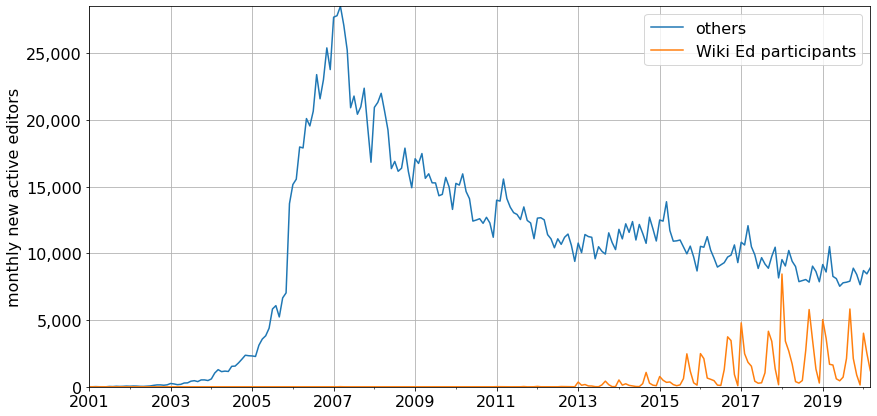

In [11]:
global_new_active_editors = new_active_editors.query("wikigroup == 'enwiki'").groupby("cohort").sum().iloc[:, [1, 0]]
global_new_active_editors.columns = ["others", "Wiki Ed participants"]
ax = global_new_active_editors.plot()
ax.set_ylabel("monthly new active editors")
ax.set_xlabel("")
ax.yaxis.set_major_formatter(comma_fmt);

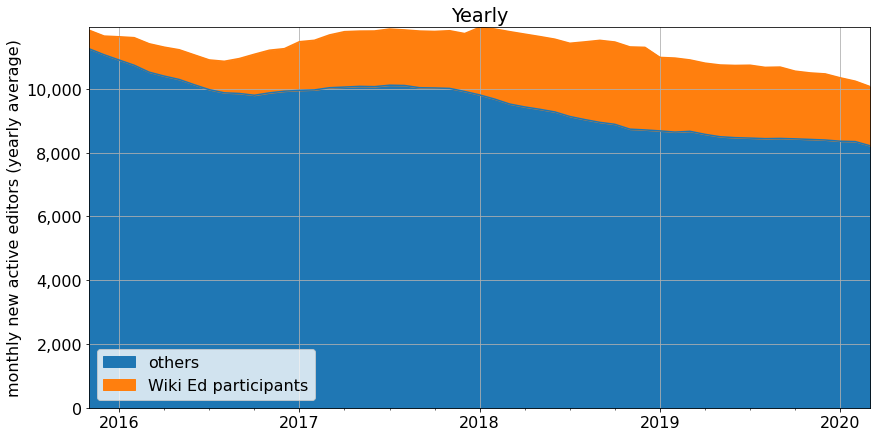

In [12]:
ax = global_new_active_editors.rolling(12).mean()["2015-11":].plot.area()
ax.set_ylabel("monthly new active editors (yearly average)")
ax.set_xlabel("")
ax.set_title("Yearly")
ax.yaxis.set_major_formatter(comma_fmt);

# English Wikipedia new editor retention

In [14]:
enwiki_new_eds_r = spark.run("""
select
    event_user_text as user_name,
    date_format(event_user_creation_timestamp, "yyyy-MM") as cohort,
    if(wefp.user_name is null, "non_wef", "wef") as type,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 0 and 30 as int)) as mo_1_edits,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 30 and 60 as int)) as mo_2_edits,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 60 and 90 as int)) as mo_3_edits,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 90 and 120 as int)) as mo_4_edits,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 120 and 150 as int)) as mo_5_edits,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 150 and 180 as int)) as mo_6_edits
from wmf.mediawiki_history mwh
left join cchen.wiki_education_foundation_participants wefp
on
    mwh.event_user_text = wefp.user_name
where
    snapshot = "2020-06" and
    wiki_db = "enwiki" and
    event_entity = "revision" and
    event_type = "create" and
    not event_user_is_created_by_system and
    event_user_creation_timestamp between "2014-12" and "2020-03" and
    event_timestamp < date_add(event_user_creation_timestamp, 180)
group by event_user_text, event_user_creation_timestamp, wefp.user_name
""")

In [15]:
enwiki_new_eds = (
    enwiki_new_eds_r
    .query("mo_1_edits > 0")
    .assign(cohort = lambda df: pd.to_datetime(df["cohort"]))
)

enwiki_new_eds.head()

,user_name,cohort,type,mo_1_edits,mo_2_edits,mo_3_edits,mo_4_edits,mo_5_edits,mo_6_edits


In [16]:
mo_2_retention = (
    enwiki_new_eds
    .groupby(["cohort", "type"])
    .agg({
        "mo_2_edits": lambda x: (x > 0).sum() / len(x)
    })
    .unstack()
    .fillna(0)
)

mo_2_retention.columns = ["others", "Wiki Ed participants"]

mo_2_retention.head()

,others,Wiki Ed participants
cohort,,
2014-12-01,0.049509,0.080808
2015-01-01,0.054692,0.751462
2015-02-01,0.048346,0.617716
2015-03-01,0.049623,0.689103
2015-04-01,0.049848,0.361257


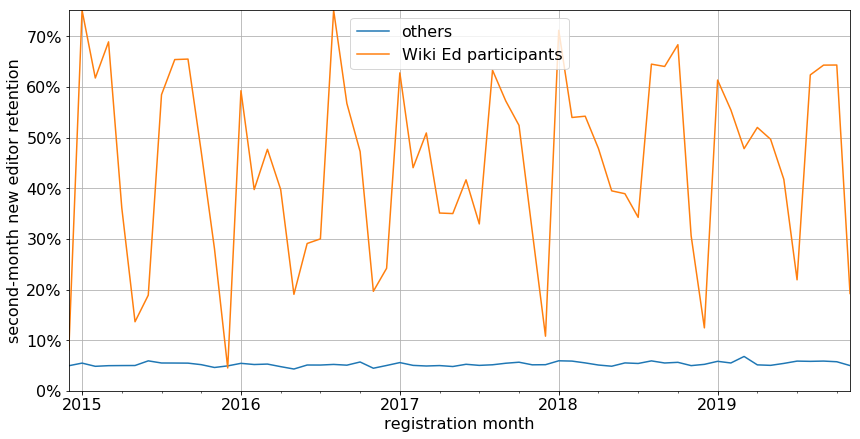

In [21]:
ax = mo_2_retention[:"2020-03-01"].plot()
plt.ylim(0)
ax.set_ylabel("second-month new editor retention")
ax.set_xlabel("registration month")
ax.yaxis.set_major_formatter(pct_fmt);

In [23]:
retention = (
    enwiki_new_eds.query("cohort > '2019-07'")
    .iloc[:, 2:]
    .groupby("type")
    .agg(lambda x: (x > 0).sum() / len(x))
    .drop("mo_1_edits", axis=1)
    .transpose()
    .assign(month=[x for x in range(2, 7)])
    .set_index("month")
    .rename(columns={
        "wef": "Wiki Ed participants",
        "non_wef": "others"
    })
    
)

retention.applymap(pct_str)

type,others,Wiki Ed participants
month,,
2,5.6%,60.6%
3,3.9%,41.7%
4,2.8%,14.1%
5,1.7%,1.6%
6,0.9%,0.8%


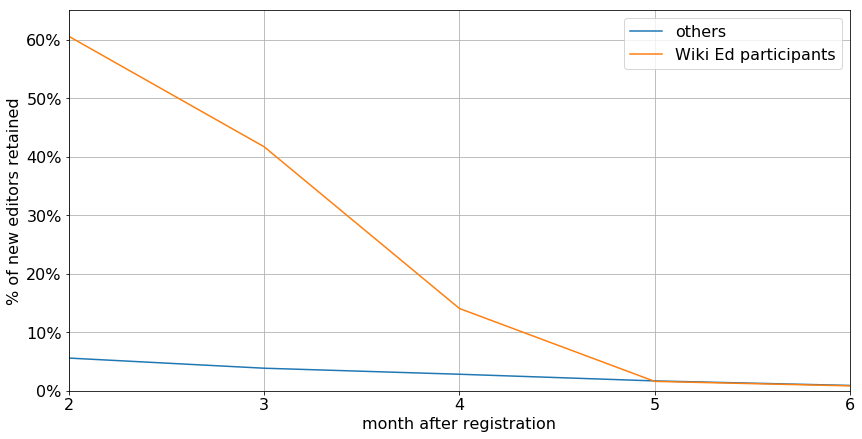

In [24]:
ax = retention.plot(ylim=(0, 0.65))

ax.xaxis.set_major_locator(mpl.ticker.IndexLocator(1, 0))
plt.xlabel("month after registration")
plt.ylabel("% of new editors retained")
plt.legend(title=None)
ax.yaxis.set_major_formatter(pct_fmt)
plt.margins(x=0.075)

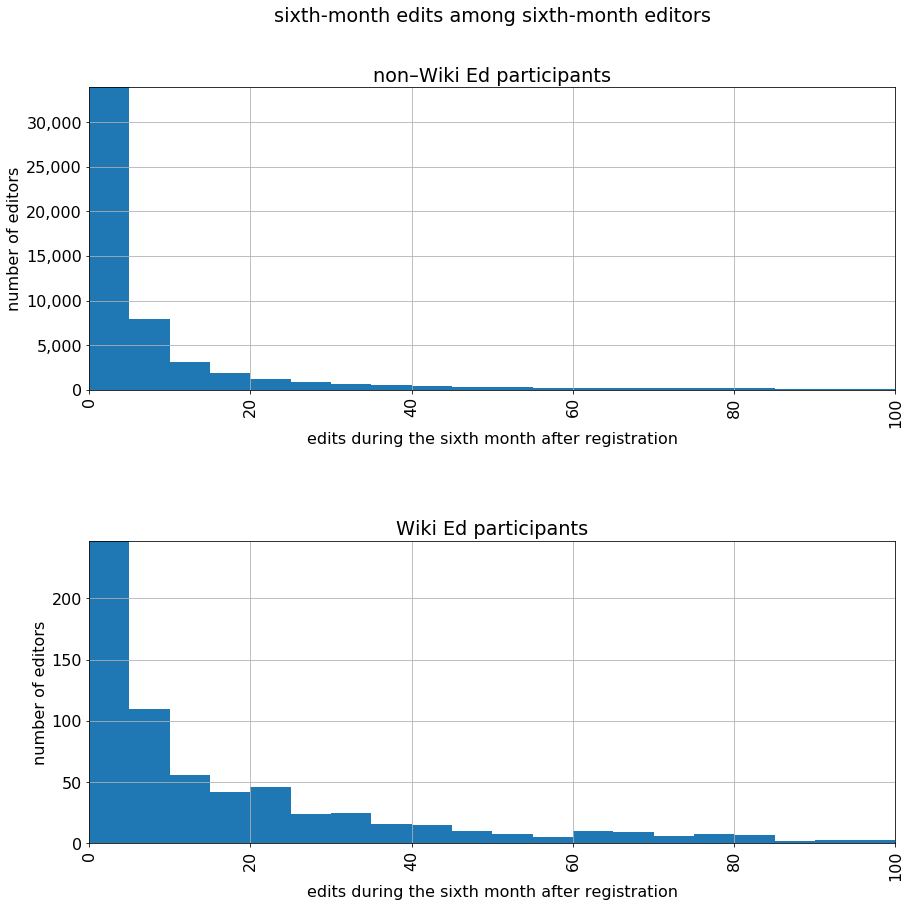

In [25]:
ax1, ax2 = enwiki_new_eds.query("mo_6_edits > 0").hist(
    column="mo_6_edits", 
    by="type",
    bins=[x for x in range(0, 105, 5)],
    layout=(2, 1), 
    figsize=(14, 14)
)
fig = plt.gcf()

fig.suptitle("sixth-month edits among sixth-month editors")
ax1.set_title("non–Wiki Ed participants")
ax2.set_title("Wiki Ed participants")

for ax in [ax1, ax2]:
    ax.set_xlabel("edits during the sixth month after registration")
    ax.set_ylabel("number of editors")
    ax.yaxis.set_major_formatter(comma_fmt)

Let's take 10 random sixth-month Wiki Edu editors and see if we can tell whether they're editing on their own now.



In [33]:
(
    enwiki_new_eds
    .query("mo_6_edits > 0")
    .query("cohort >= '2018-09-01'")
    .query("type == 'wef'")
    .sample(10, random_state=708821)
)

,user_name,cohort,type,mo_1_edits,mo_2_edits,mo_3_edits,mo_4_edits,mo_5_edits,mo_6_edits
2907449,Mbmogan,2018-09-01,wef,42,36,0,0,36,42
1108015,MetaFeta777,2019-09-01,wef,16,12,30,0,14,6
583684,Smorph0u0,2018-10-01,wef,75,10,10,40,10,35
2916709,Mayamatabele,2019-09-01,wef,54,14,4,14,0,2
1712867,JRIE97,2019-04-01,wef,12,36,0,0,0,3
1806867,ScottCoish,2019-02-01,wef,32,0,0,0,0,12
1351991,Jnf2,2019-09-01,wef,24,20,48,0,0,2
594189,XuLily,2019-08-01,wef,58,242,120,80,0,48
2753429,Mentalwhit,2019-04-01,wef,6,0,0,0,0,6
2798880,Fieldsm2019,2019-08-01,wef,57,12,12,0,0,30


- **Mbmogan** Participated in a second course
- **MetaFeta777** Participated in a second course
- **Smorph0u0** Participated in a second course
- **Mayamatabele** Returned about six months for one session of small improvements
- **JRIE97** Returned about six months and made edits to a couple of articles
- **ScottCoish** Participated in a second course
- **Jnf2** Returned the month after course to shepherd assigned article, and once ~6 months later to fix a typo
- **XuLily** Participated in a second course
- **Mentalwhit** Participated in a second course
- **Fieldsm2019** Participated in a second course